In [1]:
import numpy as np
import pandas as pd

from numba import jit, njit
from matplotlib import pyplot as plt

In [2]:
!ls

!ls md

!ls md/btcusdt:Binance:LinearPerpetual

'EDA Dolmatov draft.ipynb'  'EDA Dolmatov.ipynb'   md   plots.py
ask_trades_group.csv  btcusdt:Binance:LinearPerpetual
bid_trades_group.csv  ethusdt:Binance:LinearPerpetual
lobs.csv  trades.csv


In [3]:
def read_btc(nrows=100000):
    
    lobs = pd.read_csv('md/btcusdt:Binance:LinearPerpetual/lobs.csv', nrows=nrows)

    trades = pd.read_csv('md/btcusdt:Binance:LinearPerpetual/trades.csv', nrows=nrows)

    names = lobs.columns.values
    ln = len('btcusdt:Binance:LinearPerpetual_')
    renamer = { name:name[ln:] for name in names[2:]}
    renamer[' exchange_ts'] = 'exchange_ts'
    lobs.rename(renamer, axis=1, inplace=True)
    
    lobs["exchange_dt"] = pd.to_datetime(lobs.exchange_ts)
    trades["exchange_dt"] = pd.to_datetime(trades.exchange_ts)
    
    return lobs, trades

In [4]:
lobs, trades = read_btc(1e20)

In [5]:
print(len(lobs), len(trades))

2541356 5727714


In [6]:
lobs.tail()

,receive_ts,exchange_ts,ask_price_0,ask_vol_0,bid_price_0,bid_vol_0,ask_price_1,ask_vol_1,bid_price_1,bid_vol_1,...,bid_vol_7,ask_price_8,ask_vol_8,bid_price_8,bid_vol_8,ask_price_9,ask_vol_9,bid_price_9,bid_vol_9,exchange_dt
2541351,1656028781390653694,1656028781390000000,21089.1,0.730,21089.0,7.845,21089.3,0.001,21088.9,2.800,...,0.024,21092.5,0.55,21087.1,0.232,21092.6,0.001,21087.0,2.484,2022-06-23 23:59:41.390
2541352,1656028781423672729,1656028781423000000,21089.1,0.730,21089.0,7.845,21089.3,0.001,21088.9,2.800,...,0.024,21092.4,0.83,21087.1,0.232,21092.5,0.550,21087.0,2.484,2022-06-23 23:59:41.423
2541353,1656028781457683317,1656028781457000000,21089.1,0.736,21089.0,7.845,21089.3,0.001,21088.9,2.800,...,0.024,21092.4,0.83,21087.1,0.232,21092.5,0.550,21087.0,2.484,2022-06-23 23:59:41.457
2541354,1656028781492806433,1656028781492000000,21089.1,0.736,21089.0,7.845,21089.3,0.001,21088.9,2.800,...,0.024,21092.4,0.83,21087.1,0.232,21092.5,0.550,21087.0,2.484,2022-06-23 23:59:41.492
2541355,1656028781526713137,1656028781526000000,21089.1,0.736,21089.0,8.671,21089.3,0.001,21088.9,2.866,...,0.024,21092.4,0.83,21087.1,0.166,21092.5,0.550,21087.0,2.484,2022-06-23 23:59:41.526


In [7]:
trades.tail()

,receive_ts,exchange_ts,aggro_side,price,size,exchange_dt
5727709,1656028781074283766,1656028781073000000,BID,21089.1,0.001,2022-06-23 23:59:41.073
5727710,1656028781105532654,1656028781104000000,ASK,21089.0,0.059,2022-06-23 23:59:41.104
5727711,1656028781335919353,1656028781335000000,ASK,21089.0,0.137,2022-06-23 23:59:41.335
5727712,1656028781343654663,1656028781342000000,BID,21089.1,0.030,2022-06-23 23:59:41.342
5727713,1656028781362646546,1656028781361000000,ASK,21089.0,0.025,2022-06-23 23:59:41.361


In [8]:
ask_columns = list(filter(lambda x: x.startswith('ask'), lobs.columns.values))

bid_columns = list(filter(lambda x: x.startswith('bid'), lobs.columns.values))

dt_columns = list(set(lobs.columns) - set(ask_columns) - set(bid_columns))

In [9]:
ask_lobs = lobs[dt_columns + ask_columns].rename({name : name[4:] for name in ask_columns}, axis=1).drop(['receive_ts', 'exchange_ts'], axis=1)
bid_lobs = lobs[dt_columns + bid_columns].rename({name : name[4:] for name in bid_columns}, axis=1).drop(['receive_ts', 'exchange_ts'], axis=1)

In [10]:
def get_cum_volume(df):
    N_steps = 10
    S = np.zeros((df.shape[0], ))
    for i in range(N_steps):
        S += df[f'vol_{i}'].values
        df[f"vol_cum_{i}"] = S
    return df

In [11]:
bid_lobs = get_cum_volume(bid_lobs)
ask_lobs = get_cum_volume(ask_lobs)

In [12]:
bid_trades = trades[trades.aggro_side == 'BID'].drop(["aggro_side", "exchange_ts", "receive_ts"], axis=1).reset_index(drop=True)
ask_trades = trades[trades.aggro_side == 'ASK'].drop(["aggro_side", "exchange_ts", "receive_ts"], axis=1).reset_index(drop=True)

In [13]:
bid_trades.head()

,price,size,exchange_dt
0,19977.5,0.001,2022-06-23 00:00:02.623
1,19977.5,0.041,2022-06-23 00:00:05.292
2,19977.5,0.036,2022-06-23 00:00:05.292
3,19977.5,0.001,2022-06-23 00:00:05.292
4,19977.5,0.001,2022-06-23 00:00:05.292


In [14]:
@njit
def bar(size, price):
    Size = np.sum(size)
    mean_price = np.sum(size * price) / Size
    first_price = np.min(price)
    last_price = np.max(price)
    delta = last_price - first_price
    n_trades = len(size)
    nunique_price = np.sum( np.diff( np.sort(price) ) > 0 ) + 1
    return Size, mean_price, first_price, last_price, delta, n_trades, nunique_price


def foo(df):
    vals = bar(df['size'].values, df['price'].values)
    names = ['size', 'mean_price', 'first_price', 'last_price', 'delta','n_trades', 'nunique_price']
    return pd.Series(dict(zip(names, vals)), index=names)

Сгруппируем трейды по времени, расчитав суммарный объем сделки, средне-взвешенную цену, первую и последнюю цену, изменение цены, число трейдов, число уникальных цен во время сделки(по сути, глубину пробития стакана)

In [15]:
PROCESSED = True

In [16]:
if False:
    bid_trades_group = bid_trades.groupby(["exchange_dt"]).apply(foo)
    ask_trades_group = ask_trades.groupby(["exchange_dt"]).apply(foo)
    
    
    bid_trades_group.to_csv('md/bid_trades_group.csv')
    ask_trades_group.to_csv('md/ask_trades_group.csv')
else:
    bid_trades_group = pd.read_csv("md/bid_trades_group.csv")
    ask_trades_group = pd.read_csv("md/ask_trades_group.csv")
    
    bid_trades_group["exchange_dt"] = pd.to_datetime(bid_trades_group["exchange_dt"])
    ask_trades_group["exchange_dt"] = pd.to_datetime(ask_trades_group["exchange_dt"])

In [17]:
del lobs
del trades

In [18]:
len(bid_trades_group), len(ask_trades_group)

(1090306, 1118633)

In [19]:
bid_trades_group.head()

,exchange_dt,size,mean_price,first_price,last_price,delta,n_trades,nunique_price
0,2022-06-23 00:00:02.623,0.001,19977.500000,19977.5,19977.5,0.0,1.0,0.0
1,2022-06-23 00:00:05.292,0.086,19977.530233,19977.5,19978.0,0.5,7.0,3.0
2,2022-06-23 00:00:09.193,0.150,19978.000000,19978.0,19978.0,0.0,4.0,0.0
3,2022-06-23 00:00:09.198,0.199,19978.000000,19978.0,19978.0,0.0,1.0,0.0
4,2022-06-23 00:00:09.202,0.167,19978.000000,19978.0,19978.0,0.0,3.0,0.0


In [20]:
bid_trades_group.tail()

,exchange_dt,size,mean_price,first_price,last_price,delta,n_trades,nunique_price
1090301,2022-06-23 23:59:40.864,0.001,21089.000000,21089.0,21089.0,0.0,1.0,0.0
1090302,2022-06-23 23:59:41.043,0.003,21089.066667,21089.0,21089.1,0.1,2.0,1.0
1090303,2022-06-23 23:59:41.055,0.001,21089.100000,21089.1,21089.1,0.0,1.0,0.0
1090304,2022-06-23 23:59:41.073,0.001,21089.100000,21089.1,21089.1,0.0,1.0,0.0
1090305,2022-06-23 23:59:41.342,0.030,21089.100000,21089.1,21089.1,0.0,1.0,0.0


In [21]:
bid_trades_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090306 entries, 0 to 1090305
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   exchange_dt    1090306 non-null  datetime64[ns]
 1   size           1090306 non-null  float64       
 2   mean_price     1090306 non-null  float64       
 3   first_price    1090306 non-null  float64       
 4   last_price     1090306 non-null  float64       
 5   delta          1090306 non-null  float64       
 6   n_trades       1090306 non-null  float64       
 7   nunique_price  1090306 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 66.5 MB


## 1. Графики best bid/ask и трейдов

In [22]:
import plotly.graph_objects as go

In [83]:
N = 1000
T = bid_trades.exchange_dt[N]

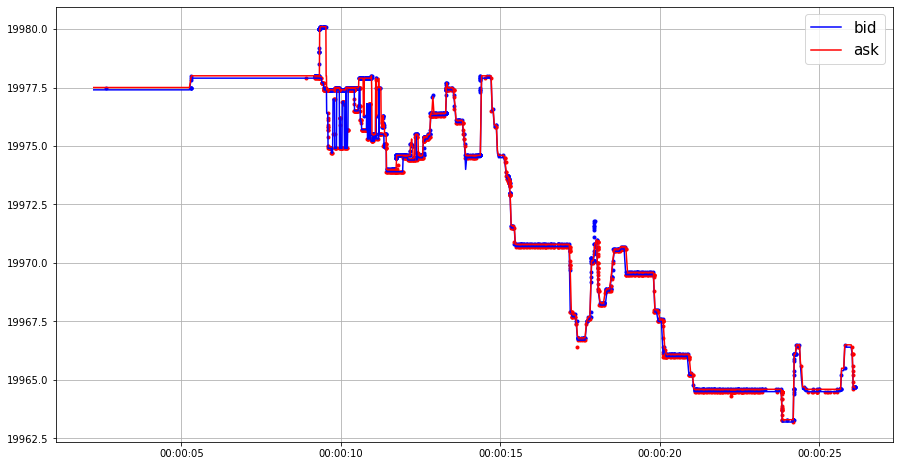

In [84]:
plt.figure(figsize=(15, 8))
plt.plot(bid_trades.exchange_dt[bid_trades.exchange_dt <= T],
         bid_trades.price[bid_trades.exchange_dt <= T], 'b.')
plt.plot(ask_trades.exchange_dt[ask_trades.exchange_dt <= T],
         ask_trades.price[ask_trades.exchange_dt <= T], 'r.')
plt.plot(bid_lobs.exchange_dt[bid_lobs.exchange_dt <= T], 
         bid_lobs.price_0[bid_lobs.exchange_dt <= T], '-b', label='bid')
plt.plot(ask_lobs.exchange_dt[ask_lobs.exchange_dt <= T],
         ask_lobs.price_0[ask_lobs.exchange_dt <= T], '-r', label='ask')
plt.legend(fontsize=15)
plt.grid()

In [85]:
def to_ochl(df):
    df_ = df.copy()
    df_["min"] = df_["exchange_dt"].dt.floor("1min")

    df_ = df_.groupby("min").agg({"mean_price" : [np.min, np.max, lambda x: x.iloc[0], lambda x:x.iloc[-1]]}).reset_index()
    df_.columns = ["exchange_dt", "low", "high", "open", "close"]
    return df_

In [86]:
ochl = to_ochl(pd.concat([bid_trades_group, ask_trades_group]))

In [87]:
ochl

,exchange_dt,low,high,open,close
0,2022-06-23 00:00:00,19963.2,20004.3,19977.500000,20004.200000
1,2022-06-23 00:01:00,19955.4,20007.1,20004.300000,19969.900000
2,2022-06-23 00:02:00,19900.0,19983.3,19970.000000,19900.014815
3,2022-06-23 00:03:00,19874.0,19965.2,19904.398872,19946.200000
4,2022-06-23 00:04:00,19946.3,20013.3,19946.300000,19977.600000
...,...,...,...,...,...
1435,2022-06-23 23:55:00,21085.9,21098.0,21086.000000,21093.400000
1436,2022-06-23 23:56:00,21086.1,21096.0,21093.500000,21091.300000
1437,2022-06-23 23:57:00,21091.3,21120.0,21091.400000,21111.800000
1438,2022-06-23 23:58:00,21086.1,21111.3,21111.300000,21093.500000


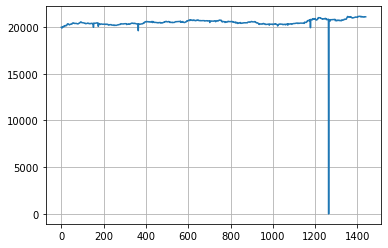

In [88]:
plt.plot(ochl.low)
plt.grid()

In [89]:
fig = go.Figure(data=[go.Candlestick(x=ochl['exchange_dt'],
                open=ochl['open'],
                high=ochl['high'],
                low=ochl['low'],
                close=ochl['close'])], layout_yaxis_range=[19500,21500])
fig.show()

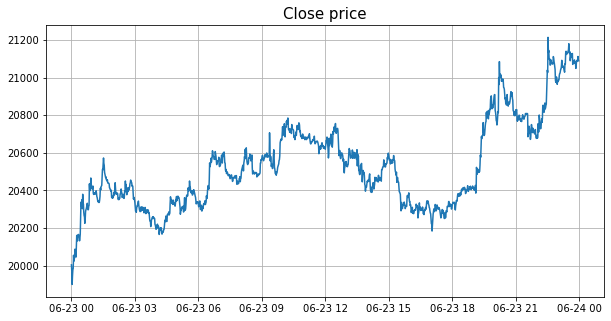

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(ochl.exchange_dt, ochl.close)
plt.grid()
plt.title("Close price", fontsize=15)
None

## 2. Статистики размеров трейда 

In [31]:
def get_statistics(data):
    mean = np.mean(data)
    std = np.std(data)
    median = np.median(data)
    q05 = np.quantile(data, 0.05)
    q25 = np.quantile(data, 0.25)
    q75 = np.quantile(data, 0.75)
    q95 = np.quantile(data, 0.95)
    
    _max = np.max(data)
    
    interq = q75 - q25
    rang   = q95 - q05
    
    
    from collections import Counter
    items = [ (fst, scnd) for fst, scnd in Counter(data).items()]
    items = sorted(items)

    sizes = [fst for fst, _ in items]
    count = [scnd for _, scnd in items]
    
    Q1 = count[0] / np.sum(count)
    Q2 = count[1] / np.sum(count)
    Q3 = count[2] / np.sum(count)
    
    S1 = sizes[0]
    S2 = sizes[1]
    S3 = sizes[2]
    
    names = ["mean", "std", "median", "q05", "q25", "q75", "q95", "max", "inq", "range", "Q1", "Q2", "Q3"]
    values = [mean, std, median, q05, q25, q75, q95, _max, interq, rang, Q1, Q2, Q3]
    
    return names, values

In [32]:
names, bid_values = get_statistics(bid_trades['size'])
_, ask_values = get_statistics(ask_trades['size'])

print("\tBid Statistics \t\t\t Ask Statistics")

for name, bid_val, ask_val in zip(names, bid_values, ask_values):
    print(f"{name} \t {bid_val:4f} \t\t\t {ask_val:4f}")

	Bid Statistics 			 Ask Statistics
mean 	 0.124643 			 0.119276
std 	 0.576416 			 0.541753
median 	 0.018000 			 0.016000
q05 	 0.001000 			 0.001000
q25 	 0.002000 			 0.001000
q75 	 0.099000 			 0.096000
q95 	 0.531000 			 0.508000
max 	 235.793000 			 211.745000
inq 	 0.097000 			 0.095000
range 	 0.530000 			 0.507000
Q1 	 0.242478 			 0.252709
Q2 	 0.043744 			 0.047229
Q3 	 0.021576 			 0.021699


Q1 это доля трейдов, у которых размер равнялся 0.001(минимальному размеру)
Q2 -- доля трейдов объёма 0.002, Q3 -- доля трейдов объема 0.003

Видно, что четверть всех трейдов имеет минимальный объём 0.001

Также видно, что есть много выбросов, в частности, среднее сильно отличается от медианы.

In [33]:
np.max(ask_trades['price']), np.min(ask_trades['price'])

(39758.88, 19874.0)

In [34]:
np.max(bid_trades['price']), np.min(bid_trades['price'])

(21250.0, 0.0)

### Статистики для объема на лучшем bid/aks уровне.

In [35]:
names, bid_values = get_statistics(bid_lobs.vol_cum_0)
_, ask_values =  get_statistics(ask_lobs.vol_cum_0)

print("\tBid Statistics \t\t\t Ask Statistics")

for name, bid_val, ask_val in zip(names[:-3], bid_values[:-3], ask_values[:-3]):
    print(f"{name} \t {bid_val:4f} \t\t\t {ask_val:4f}")

	Bid Statistics 			 Ask Statistics
mean 	 2.682905 			 2.561160
std 	 5.588090 			 4.282261
median 	 1.377000 			 1.358000
q05 	 0.012000 			 0.014000
q25 	 0.340000 			 0.347000
q75 	 3.525000 			 3.377000
q95 	 9.208250 			 8.907000
max 	 905.930000 			 434.138000
inq 	 3.185000 			 3.030000
range 	 9.196250 			 8.893000


## 3а. Гистограммы частот объёмов продаж/покупок в логарифмическом масштабе.

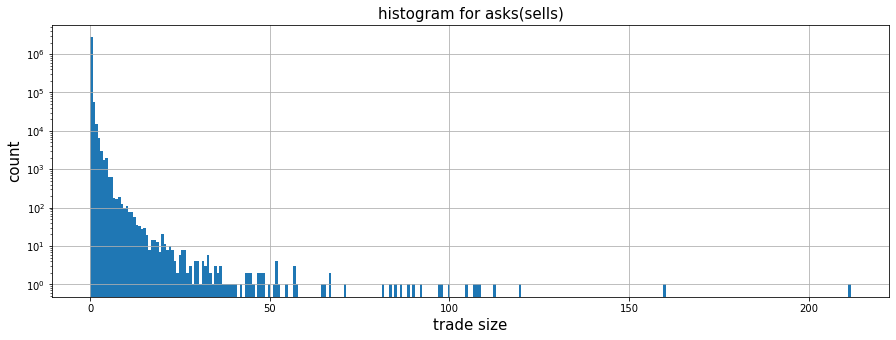

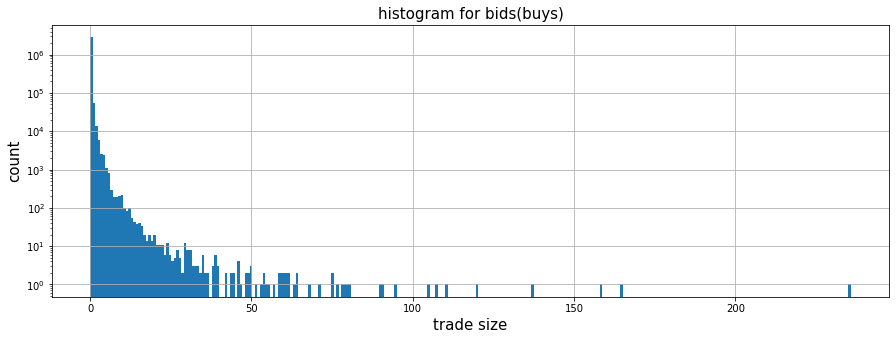

In [36]:
bid_size = bid_trades['size'].values
ask_size = ask_trades['size'].values

plt.figure(figsize=(15, 5))
plt.hist(ask_size, bins=300, log=True)
plt.title("histogram for asks(sells)", fontsize=15 )
plt.xlabel("trade size", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.grid()
plt.figure(figsize=(15, 5))
plt.hist(bid_size, bins=300, log=True)
plt.title("histogram for bids(buys)", fontsize=15 )
plt.xlabel("trade size", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.grid()

Те же самые гистограммы, только без 5% наибольших значений.

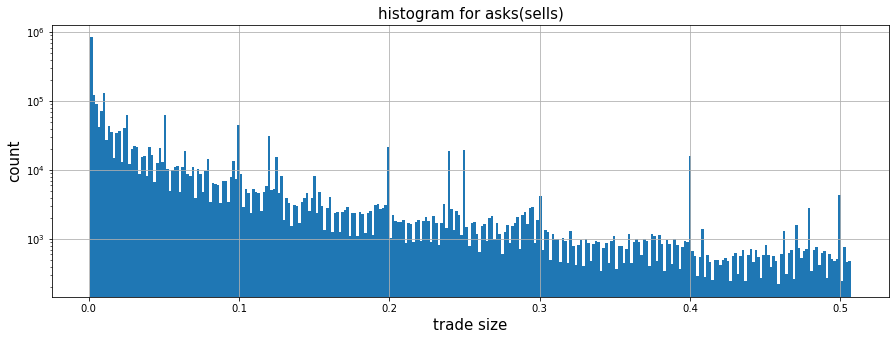

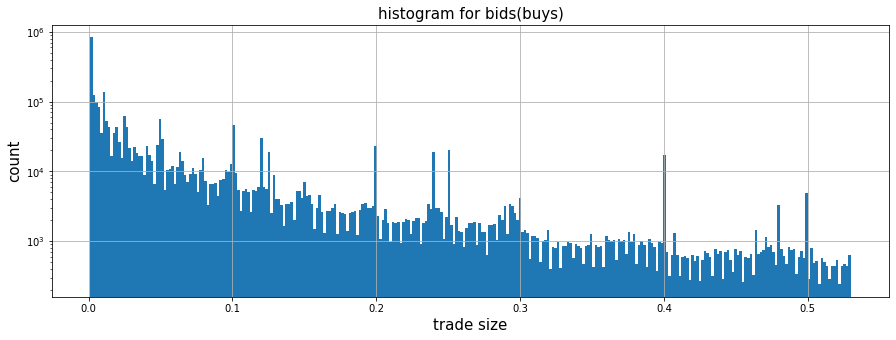

In [37]:
q1 = np.quantile(ask_size, 0.95)
q2 = np.quantile(bid_size, 0.95)

plt.figure(figsize=(15, 5))
plt.hist(ask_size[ask_size < q1], bins=300, log=True)
plt.title("histogram for asks(sells)", fontsize=15 )
plt.xlabel("trade size", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.grid()
plt.figure(figsize=(15, 5))
plt.hist(bid_size[bid_size < q2], bins=300, log=True)
plt.title("histogram for bids(buys)", fontsize=15 )
plt.xlabel("trade size", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.grid()

## 3.б Гистограммы для кумулятивных объёмов стаканов

In [38]:
def plot_volume_hist(df):
    fig, ax = plt.subplots(3, 2, figsize=(15, 15))
    for i in range(6):
        vals = df[f'vol_cum_{i}']
        q = np.quantile(vals, 0.99)
        vals = vals[vals < q]
        ax[i // 2, i % 2].hist(vals, bins=200, log=False, density=False)
        ax[i // 2, i % 2].grid()

        ax[i // 2, i % 2].set_title(f"Histogram of volume at level {i}", fontsize=15)
        ax[i // 2, i % 2].set_xlabel("volume", fontsize=10)
    plt.show()

### Bid side

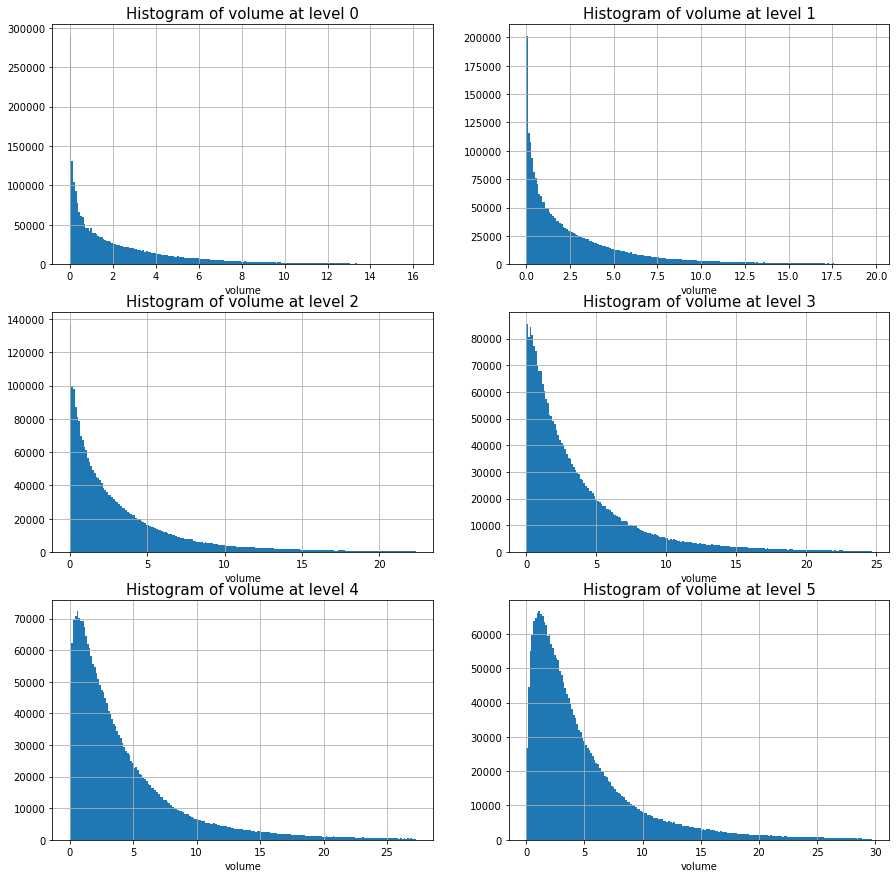

In [39]:
plot_volume_hist(bid_lobs)

### Ask side

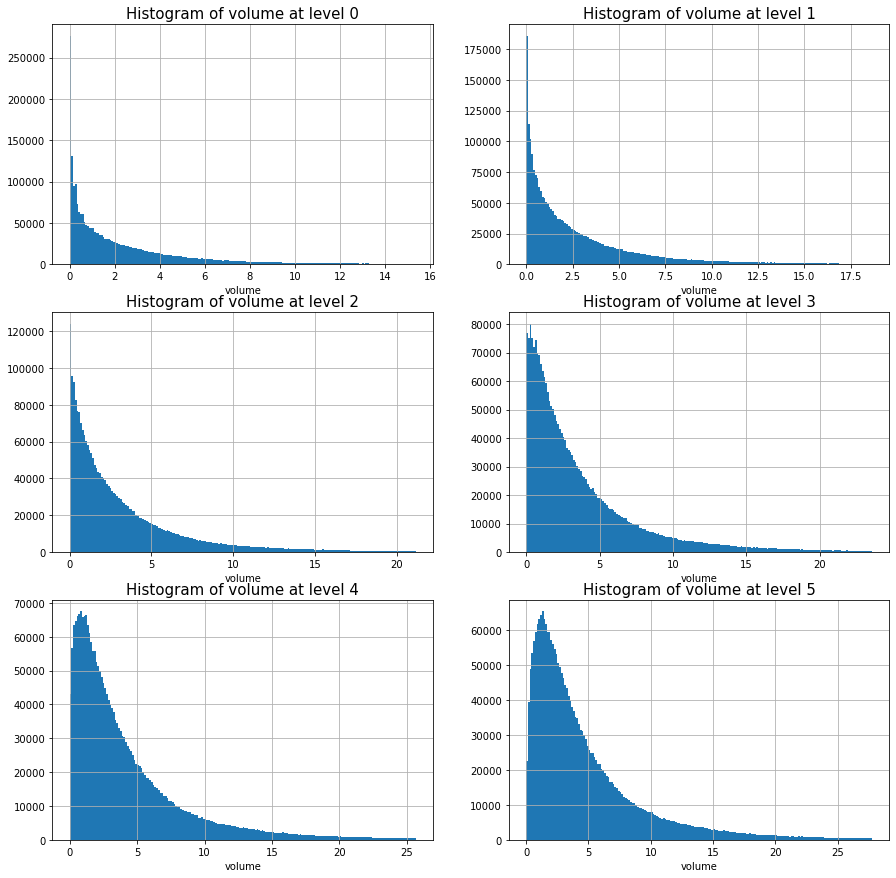

In [40]:
plot_volume_hist(ask_lobs)

## 4. величина пробития стакана

In [41]:
pd.set_option('display.max_columns', None)

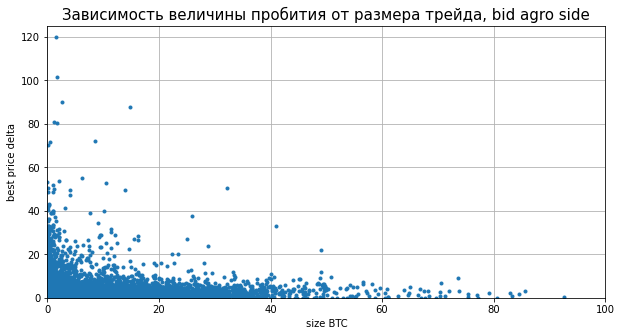

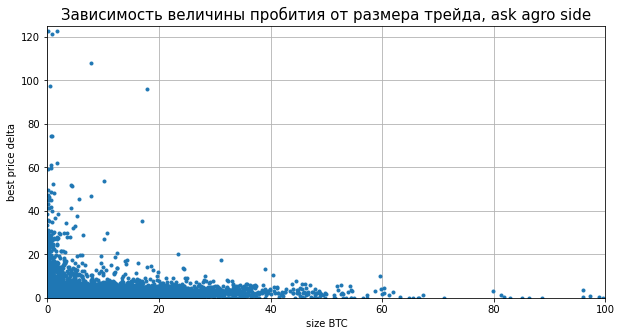

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(bid_trades_group["size"], bid_trades_group["delta"], '.')
plt.grid()
plt.title('Зависимость величины пробития от размера трейда, bid agro side', fontsize=15)
plt.xlabel('size BTC')
plt.ylabel('best price delta')
plt.ylim(0, 125)
plt.xlim(0, 100)
None

plt.figure(figsize=(10, 5))
plt.plot(ask_trades_group["size"], ask_trades_group["delta"], '.')
plt.grid()
plt.title('Зависимость величины пробития от размера трейда, ask agro side', fontsize=15)
plt.xlabel('size BTC')
plt.ylabel('best price delta')
plt.ylim(0, 125)
plt.xlim(0, 100)
None

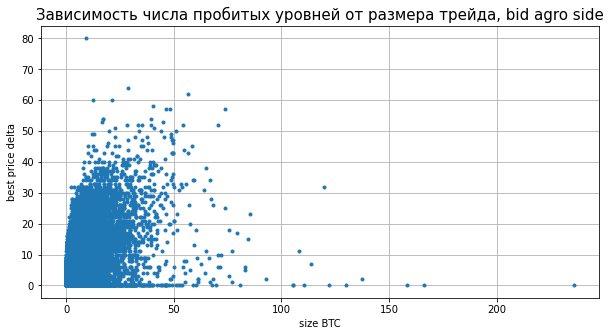

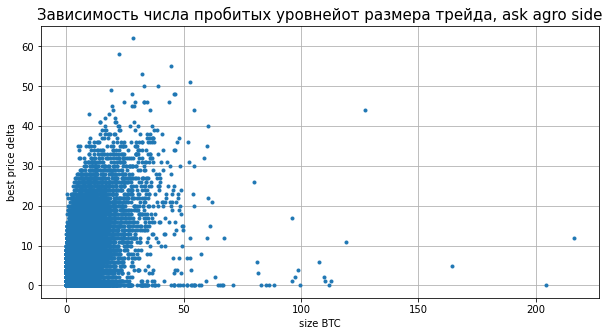

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(bid_trades_group["size"], bid_trades_group["nunique_price"], '.')
plt.grid()
plt.title('Зависимость числа пробитых уровней от размера трейда, bid agro side', fontsize=15)
plt.xlabel('size BTC')
plt.ylabel('best price delta')
None

plt.figure(figsize=(10, 5))
plt.plot(ask_trades_group["size"], ask_trades_group["nunique_price"], '.')
plt.grid()
plt.title('Зависимость числа пробитых уровнейот размера трейда, ask agro side', fontsize=15)
plt.xlabel('size BTC')
plt.ylabel('best price delta')
None

Статистики по числу пробитых уровней:

In [49]:
names, bid_values = get_statistics(bid_trades_group['nunique_price'])
_, ask_values = get_statistics(ask_trades_group['nunique_price'])

print("\tBid Staсtistics \t\t\t Ask Statistics")

for name, bid_val, ask_val in zip(names, bid_values, ask_values):
    print(f"{name} \t {bid_val:4f} \t\t\t {ask_val:4f}")

	Bid Staсtistics 			 Ask Statistics
mean 	 0.508090 			 0.482142
std 	 1.979005 			 1.860585
median 	 0.000000 			 0.000000
q05 	 0.000000 			 0.000000
q25 	 0.000000 			 0.000000
q75 	 0.000000 			 0.000000
q95 	 3.000000 			 3.000000
max 	 80.000000 			 62.000000
inq 	 0.000000 			 0.000000
range 	 3.000000 			 3.000000
Q1 	 0.862556 			 0.864874
Q2 	 0.046753 			 0.046885
Q3 	 0.026481 			 0.026107


Видно, что в большинстве трейдов (86%) не происходит пробития стакана. На один уровень пробивается лишь 4% трейдов, на 2 -- 2%. Однако есть единичные заявки, которые пробивают 80 уровней.

In [54]:
np.max(ask_trades["price"].values)

39758.88

In [64]:
i = np.argmax(ask_trades["price"].values)

T1 = ask_trades.exchange_dt.iloc[i - 5]
T2 = ask_trades.exchange_dt.iloc[i + 5]

In [65]:
ask_trades.iloc[i - 5 : i + 5]

,price,size,exchange_dt
2254154,20845.70,0.003,2022-06-23 19:47:25.762
2254155,20845.70,0.001,2022-06-23 19:47:25.762
2254156,20845.70,0.028,2022-06-23 19:47:25.791
2254157,20845.70,0.007,2022-06-23 19:47:25.791
2254158,20845.70,0.001,2022-06-23 19:47:25.798
2254159,39758.88,0.001,2022-06-23 19:47:25.836
2254160,20845.70,0.001,2022-06-23 19:47:25.843
2254161,20845.70,0.300,2022-06-23 19:47:25.863
2254162,20845.70,0.101,2022-06-23 19:47:25.875
2254163,20845.70,0.159,2022-06-23 19:47:25.875


In [67]:
bid_trades[ (bid_trades.exchange_dt >= T1) & (bid_trades.exchange_dt <= T2) ]

,price,size,exchange_dt
2312886,20845.8,0.001,2022-06-23 19:47:25.762
2312887,20845.8,0.010,2022-06-23 19:47:25.772
2312888,20845.8,0.009,2022-06-23 19:47:25.772
2312889,20845.8,0.001,2022-06-23 19:47:25.798
2312890,20845.8,0.100,2022-06-23 19:47:25.803
2312891,20845.8,0.089,2022-06-23 19:47:25.821
2312892,20845.8,0.001,2022-06-23 19:47:25.841


In [69]:
bid_lobs[ (bid_lobs.exchange_dt >= T1) & (bid_lobs.exchange_dt <= T2)  ]

,exchange_dt,price_0,vol_0,price_1,vol_1,price_2,vol_2,price_3,vol_3,price_4,vol_4,price_5,vol_5,price_6,vol_6,price_7,vol_7,price_8,vol_8,price_9,vol_9,vol_cum_0,vol_cum_1,vol_cum_2,vol_cum_3,vol_cum_4,vol_cum_5,vol_cum_6,vol_cum_7,vol_cum_8,vol_cum_9
2097318,2022-06-23 19:47:25.774,20845.7,3.535,20845.6,6.885,20845.2,0.200,20845.0,0.010,20844.8,0.655,20844.7,0.261,20844.6,0.007,20844.5,0.070,20844.4,0.008,20844.3,0.011,3.535,10.420,10.620,10.630,11.285,11.546,11.553,11.623,11.631,11.642
2097319,2022-06-23 19:47:25.807,20845.7,7.806,20845.6,0.385,20845.2,0.200,20845.0,0.010,20844.8,0.655,20844.7,0.261,20844.6,0.007,20844.5,0.070,20844.4,0.008,20844.3,0.011,7.806,8.191,8.391,8.401,9.056,9.317,9.324,9.394,9.402,9.413
2097320,2022-06-23 19:47:25.840,20845.7,2.689,20845.6,0.001,20845.2,0.200,20845.0,0.010,20844.8,0.055,20844.7,1.061,20844.6,0.007,20844.5,0.070,20844.4,0.008,20844.3,0.011,2.689,2.690,2.890,2.900,2.955,4.016,4.023,4.093,4.101,4.112
2097321,2022-06-23 19:47:25.873,20845.7,2.382,20845.0,0.010,20844.8,0.055,20844.7,1.061,20844.6,0.007,20844.5,0.004,20844.4,0.008,20844.3,0.011,20844.1,0.182,20844.0,0.600,2.382,2.392,2.447,3.508,3.515,3.519,3.527,3.538,3.720,4.320


In [79]:
j = np.argmax(ask_trades_group.nunique_price.values)


T1 = ask_trades_group.exchange_dt.iloc[j - 5]
T2 = ask_trades_group.exchange_dt.iloc[j + 15]

In [80]:
ask_trades_group.iloc[j - 5 : j + 5]

,exchange_dt,size,mean_price,first_price,last_price,delta,n_trades,nunique_price
1007736,2022-06-23 21:43:02.150,0.001,20672.700000,20672.7,20672.7,0.0,1.0,0.0
1007737,2022-06-23 21:43:02.171,0.077,20672.700000,20672.7,20672.7,0.0,2.0,0.0
1007738,2022-06-23 21:43:02.355,0.002,20672.700000,20672.7,20672.7,0.0,1.0,0.0
1007739,2022-06-23 21:43:02.361,0.150,20672.700000,20672.7,20672.7,0.0,4.0,0.0
1007740,2022-06-23 21:43:02.374,1.772,20671.588375,20670.3,20672.7,2.4,21.0,11.0
1007741,2022-06-23 21:43:02.377,28.304,20663.536415,20660.0,20670.1,10.1,116.0,62.0
1007742,2022-06-23 21:43:02.378,6.320,20659.317848,20657.8,20660.0,2.2,24.0,12.0
1007743,2022-06-23 21:43:02.381,12.386,20656.546262,20656.2,20657.6,1.4,25.0,12.0
1007744,2022-06-23 21:43:02.383,18.748,20655.931107,20655.9,20656.1,0.2,24.0,2.0
1007745,2022-06-23 21:43:02.386,29.424,20655.037626,20655.0,20655.8,0.8,28.0,7.0


In [82]:
ask_lobs[ (ask_lobs.exchange_dt >= T1) & (ask_lobs.exchange_dt <= T2)  ]

,exchange_dt,price_0,vol_0,price_1,vol_1,price_2,vol_2,price_3,vol_3,price_4,vol_4,price_5,vol_5,price_6,vol_6,price_7,vol_7,price_8,vol_8,price_9,vol_9,vol_cum_0,vol_cum_1,vol_cum_2,vol_cum_3,vol_cum_4,vol_cum_5,vol_cum_6,vol_cum_7,vol_cum_8,vol_cum_9
2301883,2022-06-23 21:43:02.153,20672.8,2.571,20673.0,6.813,20673.2,0.008,20673.5,0.001,20674.0,0.072,20674.1,0.015,20674.5,0.051,20674.6,0.290,20674.7,0.304,20674.9,0.169,2.571,9.384,9.392,9.393,9.465,9.480,9.531,9.821,10.125,10.294
2301884,2022-06-23 21:43:02.189,20672.8,2.422,20673.0,6.813,20673.2,0.008,20673.5,0.001,20674.0,0.072,20674.1,0.015,20674.5,0.051,20674.6,0.290,20674.7,0.304,20675.0,0.346,2.422,9.235,9.243,9.244,9.316,9.331,9.382,9.672,9.976,10.322
2301885,2022-06-23 21:43:02.222,20672.8,2.422,20673.0,6.813,20673.2,0.008,20673.5,0.001,20674.0,0.072,20674.1,0.015,20674.5,0.051,20674.6,0.290,20674.7,0.304,20675.0,0.346,2.422,9.235,9.243,9.244,9.316,9.331,9.382,9.672,9.976,10.322
2301886,2022-06-23 21:43:02.258,20672.8,2.422,20673.0,7.141,20673.2,0.008,20673.5,0.001,20674.0,0.072,20674.1,0.015,20674.5,0.051,20674.6,0.290,20674.7,0.304,20675.0,0.346,2.422,9.563,9.571,9.572,9.644,9.659,9.710,10.000,10.304,10.650
2301887,2022-06-23 21:43:02.295,20672.8,2.422,20673.0,7.141,20673.2,0.008,20673.5,0.001,20674.0,0.072,20674.1,0.015,20674.5,0.051,20674.6,0.290,20674.7,0.304,20675.0,0.346,2.422,9.563,9.571,9.572,9.644,9.659,9.710,10.000,10.304,10.650
2301888,2022-06-23 21:43:02.340,20672.8,2.420,20673.0,7.140,20673.2,0.008,20673.5,0.001,20674.0,0.072,20674.1,0.015,20674.5,0.051,20674.6,0.290,20674.7,0.304,20675.0,0.346,2.420,9.560,9.568,9.569,9.641,9.656,9.707,9.997,10.301,10.647
2301889,2022-06-23 21:43:02.373,20672.8,2.420,20673.0,7.140,20673.2,0.008,20673.5,0.001,20674.0,0.072,20674.1,0.015,20674.5,0.051,20674.6,0.290,20674.7,0.304,20675.0,0.346,2.420,9.560,9.568,9.569,9.641,9.656,9.707,9.997,10.301,10.647
2301890,2022-06-23 21:43:02.406,20668.7,0.758,20669.7,0.574,20670.1,0.100,20671.0,0.179,20671.3,0.224,20671.5,0.176,20671.7,0.075,20671.9,0.011,20672.1,0.097,20672.3,2.113,0.758,1.332,1.432,1.611,1.835,2.011,2.086,2.097,2.194,4.307
2301891,2022-06-23 21:43:02.438,20667.5,0.131,20667.7,4.167,20667.8,0.051,20668.0,0.168,20668.2,0.392,20668.3,0.279,20668.4,0.817,20668.6,0.221,20668.7,2.259,20668.8,0.312,0.131,4.298,4.349,4.517,4.909,5.188,6.005,6.226,8.485,8.797
2301892,2022-06-23 21:43:02.470,20662.4,0.192,20662.6,0.128,20663.0,0.201,20663.6,0.575,20663.9,0.284,20664.5,0.125,20666.0,0.015,20667.2,0.360,20667.3,0.713,20667.4,2.648,0.192,0.320,0.521,1.096,1.380,1.505,1.520,1.880,2.593,5.241
